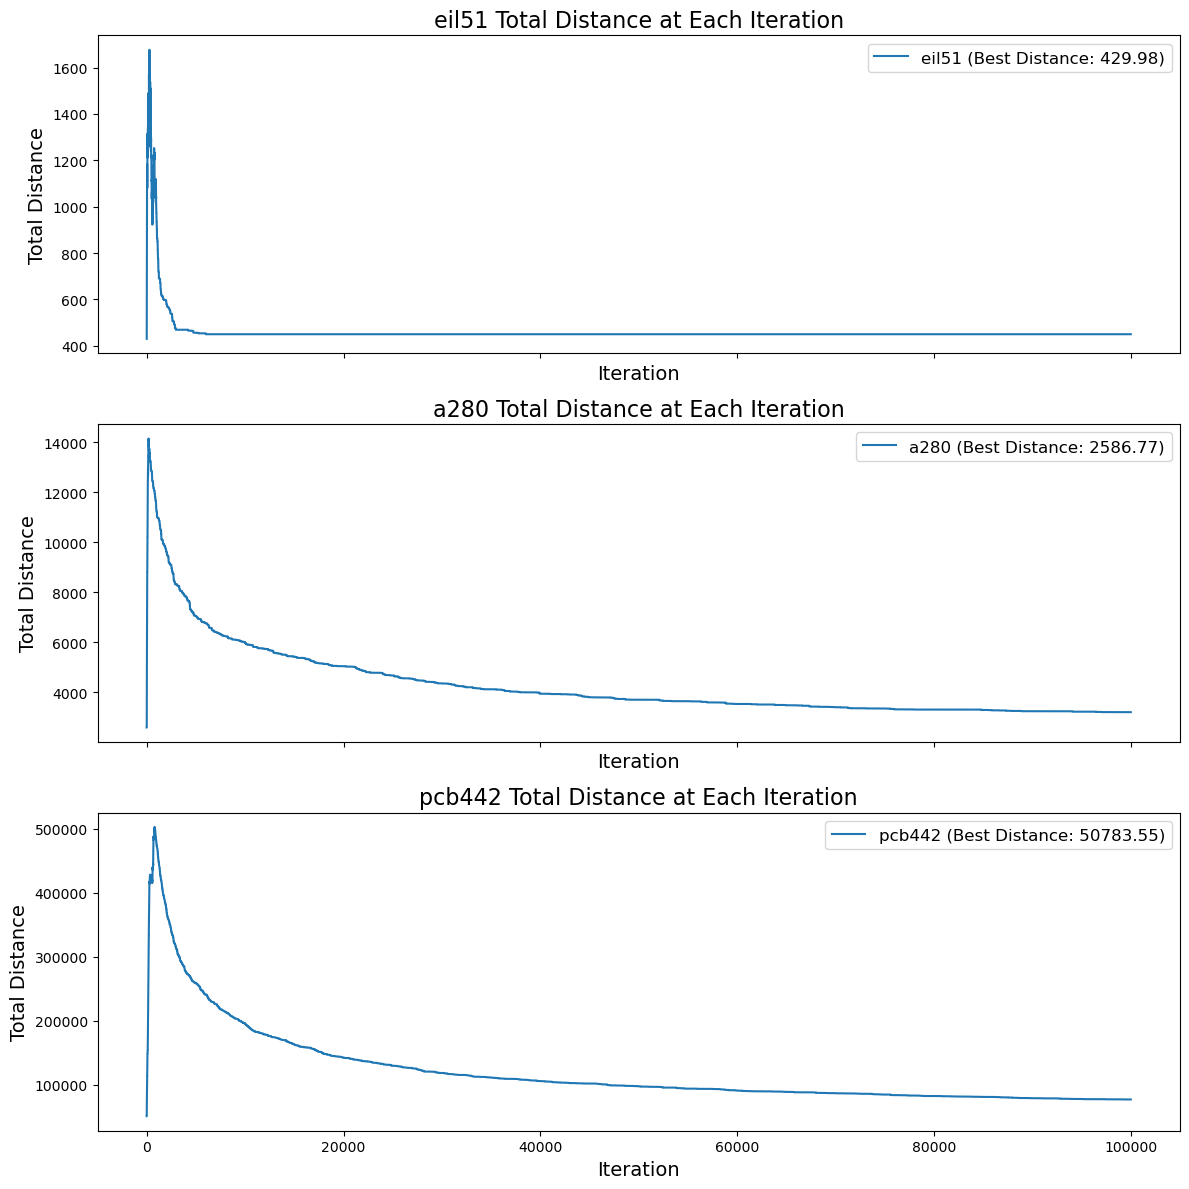

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import random
import math
import re

# Functions to read TSP and tour data
def read_tsp_file(filename):
    with open(filename, 'r') as file:
        lines = file.read().splitlines()
    coordinates = {}
    for line in lines:
        if line.startswith('NODE_COORD_SECTION'):
            break
    for line in lines[lines.index('NODE_COORD_SECTION') + 1:]:
        if line.strip() == 'EOF':
            break
        parts = line.split()
        coordinates[int(parts[0])] = (float(parts[1]), float(parts[2]))
    return coordinates

def read_tour_file(filename):
    with open(filename, 'r') as file:
        lines = file.read().splitlines()
    tour = []
    for line in lines:
        if line.startswith('TOUR_SECTION'):
            break
    for line in lines[lines.index('TOUR_SECTION') + 1:]:
        if line.strip() == '-1' or re.match(r'EOF', line.strip()):
            break
        tour.append(int(line.strip()))
    return tour

# Euclidean distance calculation
def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

# Total distance calculation for a tour
def calculate_total_distance(tour, coordinates):
    total_distance = 0
    for i in range(-1, len(tour) - 1):
        total_distance += euclidean_distance(coordinates[tour[i]], coordinates[tour[i + 1]])
    return total_distance

# 2-opt swap function
def two_opt(route, i, k):
    new_route = route[:i] + route[i:k+1][::-1] + route[k+1:]
    return new_route

# Stochastic annealing with 2-opt
def stochastic_annealing_2opt(coordinates, initial_route, cooling_rate, number_of_iterations):
    current_route = initial_route
    best_route = initial_route[:]
    current_distance = calculate_total_distance(current_route, coordinates)
    best_distance = current_distance
    temperature = max([euclidean_distance(coordinates[i], coordinates[j]) 
                       for i in coordinates for j in coordinates])

    distances = [current_distance]

    for iteration in range(number_of_iterations):
        i, k = sorted(random.sample(range(1, len(current_route) - 1), 2))
        new_route = two_opt(current_route, i, k)
        new_distance = calculate_total_distance(new_route, coordinates)

        delta_distance = new_distance - current_distance

        if delta_distance < 0 or random.random() < math.exp(-delta_distance / temperature):
            current_route = new_route
            current_distance = new_distance

            if new_distance < best_distance:
                best_route = new_route
                best_distance = new_distance

        distances.append(current_distance)
        temperature *= cooling_rate * np.random.normal(1, 0.1)

        # Periodic temperature Boost 
        if iteration % 100 == 0:
            temperature *= 1.1

    return best_route, best_distance, distances

# TSP file names
tsp_files = ['eil51.tsp.txt', 'a280.tsp.txt', 'pcb442.tsp.txt']
tour_files = ['eil51.opt.tour.txt', 'a280.opt.tour.txt', 'pcb442.opt.tour.txt']

# Stochastic Annealing parameters
cooling_rate = 0.995
number_of_iterations = 100000

# Store distances for each TSP instance
all_distances = []

# Process each TSP instance
for tsp_file, tour_file in zip(tsp_files, tour_files):
    coordinates = read_tsp_file(tsp_file)
    initial_route = read_tour_file(tour_file)
    _, best_distance, distances = stochastic_annealing_2opt(coordinates, initial_route, cooling_rate, number_of_iterations)
    all_distances.append((tsp_file[:-8], distances))

# Set up the subplots
fig, axs = plt.subplots(len(all_distances), 1, figsize=(12, 12), sharex=True)

# Plot each TSP instance in a separate subplot
for i, (name, distances) in enumerate(all_distances):
    axs[i].plot(distances, label=f'{name} (Best Distance: {min(distances):.2f})')
    axs[i].set_title(f'{name} Total Distance at Each Iteration', fontsize=16) 
    axs[i].set_xlabel('Iteration', fontsize=14) 
    axs[i].set_ylabel('Total Distance', fontsize=14) 
    axs[i].legend(fontsize=12) 

# Adjust the layout so that the titles and labels do not overlap
plt.tight_layout()

# Display the figure
plt.show()

Three Different Cooling Schedules

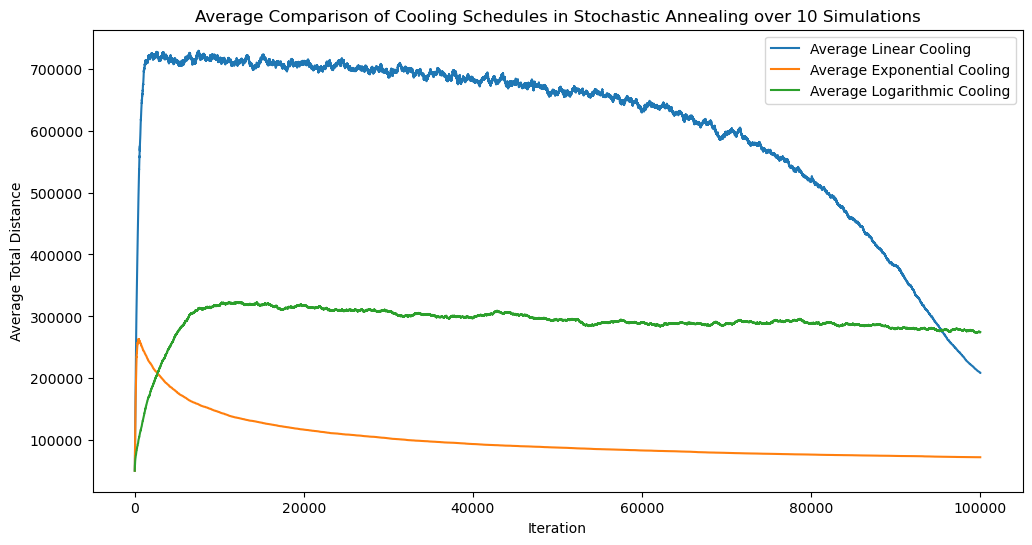

In [3]:
def linear_cooling(initial_temp, iteration, total_iterations):
    return initial_temp * (1 - (iteration / total_iterations))

def exponential_cooling(initial_temp, iteration, cooling_rate):
    return initial_temp * (cooling_rate ** iteration)

def logarithmic_cooling(initial_temp, iteration, beta):
    return initial_temp / (1 + beta * math.log(1 + iteration))

def stochastic_annealing_2opt(coordinates, initial_route, cooling_schedule, schedule_params, number_of_iterations):
    current_route = initial_route
    best_route = initial_route[:]
    current_distance = calculate_total_distance(current_route, coordinates)
    best_distance = current_distance
    initial_temp = max([euclidean_distance(coordinates[i], coordinates[j]) 
                        for i in coordinates for j in coordinates])

    distances = [current_distance]

    for iteration in range(number_of_iterations):
        temperature = cooling_schedule(initial_temp, iteration, **schedule_params)

        i, k = sorted(random.sample(range(1, len(current_route) - 1), 2))
        new_route = two_opt(current_route, i, k)
        new_distance = calculate_total_distance(new_route, coordinates)

        delta_distance = new_distance - current_distance
        if delta_distance < 0 or random.random() < math.exp(-delta_distance / temperature):
            current_route = new_route
            current_distance = new_distance
            if new_distance < best_distance:
                best_route = new_route
                best_distance = new_distance

        distances.append(current_distance)
        # Reintroduce some heat periodically to avoid local minima
        if iteration % 100 == 0:
            temperature *= 1.1  # Increase the temperature by 10% every 100 iterations
    return best_route, best_distance, distances

# Define simulation function
def simulate_annealing(coordinates, initial_route, number_of_iterations):
    linear_params = {'total_iterations': number_of_iterations}
    exponential_params = {'cooling_rate': 0.995}
    logarithmic_params = {'beta': 1}
    number_of_iterations = 100000
    _, _, distances_linear = stochastic_annealing_2opt(
        coordinates, initial_route, linear_cooling, linear_params, number_of_iterations)
    _, _, distances_exponential = stochastic_annealing_2opt(
        coordinates, initial_route, exponential_cooling, exponential_params, number_of_iterations)
    _, _, distances_logarithmic = stochastic_annealing_2opt(
        coordinates, initial_route, logarithmic_cooling, logarithmic_params, number_of_iterations)

    return distances_linear, distances_exponential, distances_logarithmic

# Initialize accumulators for distances
accumulated_distances_linear = []
accumulated_distances_exponential = []
accumulated_distances_logarithmic = []

# Run simulations 10 times
for _ in range(10):
    distances_linear, distances_exponential, distances_logarithmic = simulate_annealing(
        coordinates, initial_route, number_of_iterations)

    accumulated_distances_linear.append(distances_linear)
    accumulated_distances_exponential.append(distances_exponential)
    accumulated_distances_logarithmic.append(distances_logarithmic)

# Calculating average distances
average_distances_linear = np.mean(accumulated_distances_linear, axis=0)
average_distances_exponential = np.mean(accumulated_distances_exponential, axis=0)
average_distances_logarithmic = np.mean(accumulated_distances_logarithmic, axis=0)

# Plotting average distances
plt.figure(figsize=(12, 6))
plt.plot(average_distances_linear, label='Average Linear Cooling')
plt.plot(average_distances_exponential, label='Average Exponential Cooling')
plt.plot(average_distances_logarithmic, label='Average Logarithmic Cooling')
plt.xlabel('Iteration')
plt.ylabel('Average Total Distance')
plt.title('Average Comparison of Cooling Schedules in Stochastic Annealing over 10 Simulations')
plt.legend()
plt.show()

### Markov Chain Length Effects Convegence

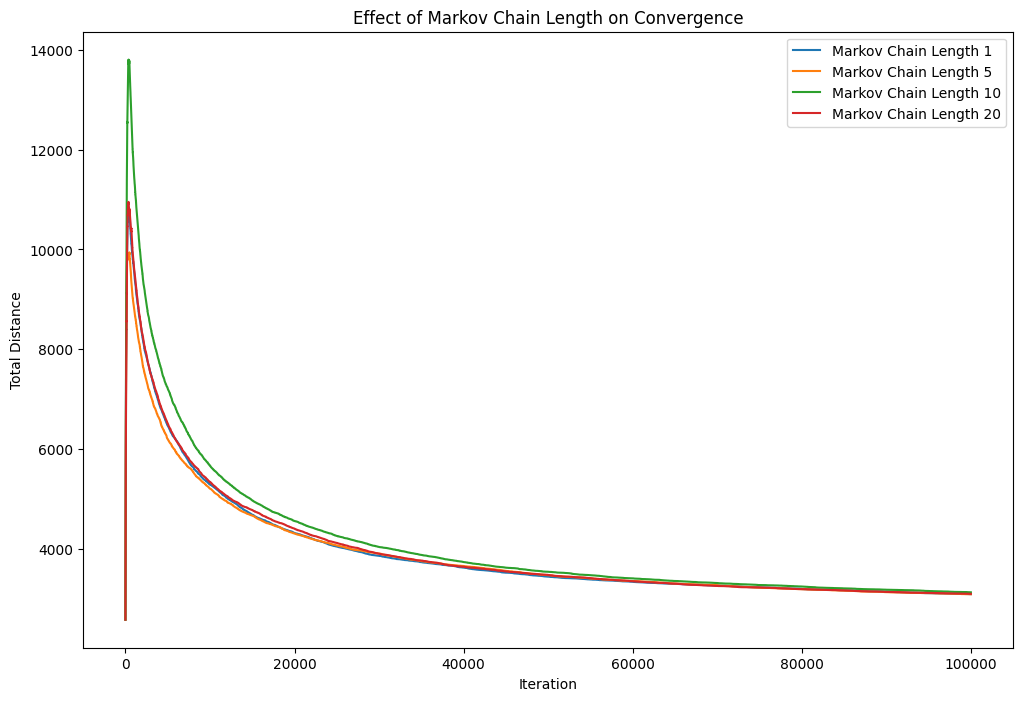

In [ ]:
def markov_length_effect(coordinates, initial_route, cooling_rate, number_of_iterations, markov_lengths, num_simulations=20):
    results = {}
    convergence_speed = {}

    for length in markov_lengths:
        all_distances = []
        for _ in range(num_simulations):
            _, _, distances = stochastic_annealing_2opt(
                coordinates, initial_route, cooling_rate, number_of_iterations
            )
            all_distances.append(distances)
        
        # Calculate the average total distance
        average_distances = np.mean(all_distances, axis=0) # mean value of 20 runs
        results[length] = average_distances

        # Determine convergence speed
        target_distance = np.min(average_distances) * 1.05  # Target set to 105% of the best found
        for i, dist in enumerate(average_distances):
            if dist <= target_distance:
                convergence_speed[length] = i
                break

    return results, convergence_speed

markov_lengths = [1, 5, 10, 20]  # Example Markov Chain lengths
results, convergence_speed = markov_length_effect(coordinates, initial_route, cooling_rate, number_of_iterations, markov_lengths)

# Plotting the distances outside the function
plt.figure(figsize=(12, 8))
for length, distances in results.items():
    plt.plot(distances, label=f'Markov Chain Length {length}')

plt.xlabel('Iteration')
plt.ylabel('Total Distance')
plt.title('Effect of Markov Chain Length on Convergence')
plt.legend()
plt.show()

plt.savefig("pic1",dpi=300)